# COMP24112 Summative Exercise: Air Quality Analysis (30 Marks)

This lab exercise is about air quality analysis, where you will predict air quality through solving classification and regression tasks. You will submit a notebook file, a pdf report, and a trained model. You will be marked for implementation, design, result and analysis. Your code should be easy to read and your report should be concise (max 600 words). It is strongly recommended that you use a LaTeX editor, such as [Overleaf](https://www.overleaf.com/), to write your report.

Please note your notebook should take no more than 10 minutes to run on lab computers. **There is 1 mark for code efficiency.**

## 1. Dataset and Knowledge Preparation

The provided dataset contains measurements of air quality from a multisensor device. The device used spectrometer analyzers (variables marked by "GT") and solid state metal oxide detectors (variables marked by "PT08.Sx"), as well as temperature (T), relative humidity (RH) and absolute humidity (AH) sensors. 

The dataset contains 3304 instances of hourly averaged measurements taken at road level in a polluted city. You will predict the CO(GT) variable representing carbon monoxide levels. There are missing features in this dataset, flagged by the number `-999`. 

You will need to pre-process the dataset to handle missing features, for which please self-learn from scikit-learn on how to [impute missing values](https://scikit-learn.org/stable/modules/impute.html). You will need to split the dataset into training and testing sets, also to run cross validation, when you see fit. For this, please self-learn from scikit-learn on [data splitting](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html).   

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import sklearn.model_selection

notebook_start_time = time.time()

# Import data - it should be saved in the same root directory as this notebook
sensor_data_full = pd.read_excel('sensor_data.xlsx')

# Display a sample of the data
sensor_data_full.sample(5)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
2075,5.8,1476.00,24.966344,1428.25,1048.8,476.50,235.0,1535.75,1973.75,5.575,52.900001,0.484055
2149,2.4,1199.50,8.731502,928.75,288.0,664.25,132.0,1082.25,1847.00,4.200,63.099999,0.525897
1152,0.2,857.75,2.695146,632.50,97.0,1135.50,73.0,878.00,788.25,3.475,55.875000,0.443135
3057,6.3,1617.75,29.115771,1530.00,326.0,579.00,171.0,2166.50,1791.00,18.000,32.950000,0.673743
2516,0.9,919.75,4.823872,754.50,108.0,852.75,45.0,1359.25,879.75,19.975,66.700001,1.540080


## 2. Linear Classification via Gradient Descent (13 marks)

The air quality is assessed using the CO(GT) variable. If it is no greater than 4.5, the air quality is good (CO(GT)<=4.5), otherwise, it is bad  (CO(GT)>4.5). You will perform binary classification to predict whether the air quality is good based on the other 11 varivables, i.e., from PT08.S1(CO) to AH. 

### 2.1 Model Training and Testing (4 marks)

This practice is about training a binary linear classifier by minimising a hinge loss with L2 (ridge) regularisation, and then testing its performance. Given a set of $N$ training samples $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where $\mathbf{x}_i$ is the feature vector and $y_i \in \{-1, +1\}$ is the class label for the $i$-th training sample, the training objective function to minimise is 
$$O = C \sum^N_{i=1}\max\left(0, 1 - y_i \left(\mathbf{w}^T\mathbf{x}_i + w_0\right)\right) + \frac{1}{2}\mathbf{w}^T\mathbf{w}. $$
Here, $\mathbf{w}$ is a column weight vector of the linear model, $w_0$ is the bias parameter of the model, and $C$ is the regularisation hyperparameter.

Recall from your lectures that gradient descent is an iterative optimisation algorithm typically used in model training. Complete the implmentation of the training function `linear_gd_train` below, which trains your linear model by minimising the above provided training objective function $O$ using gradient descent.

The function should return the trained model weights and the corresponding objective function value (referred to as cost) per iteration. In addition to the training data, the function should take the regularisation hyperparameter $C$, learning rate $\eta$, and the number of iterations $N_{max}$ as arguments. A default setting of these parameters has been provided below, which is able to provide reasonably good performance.  

**Note that scikit-learn is not allowed for implementation in this section.** We recommend that you avoid using `for` loops in your implementation of the objective function or weight update, and instead use built-in numpy operations for efficiency. 

In [2]:
def linear_gd_train(data, labels, c=0.2, n_iters=200, learning_rate=0.001, random_state=None # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: training data
    labels: training labels (boolean)
    c: regularisation parameter
    n_iters: number of iterations
    learning_rate: learning rate for gradient descent

    Returns an array of cost and model weights per iteration.
    """
    # Set random seed for reproducibility if using random initialisation of weights (optional)
    rng = np.random.default_rng(seed=random_state)

    # Create design matrix and labels
    # using hstack for array of 1s, as many rows as in the dataset, bias term
    X_tilde = np.hstack((data, np.ones((data.shape[0], 1))))
    # converts booleans to float for -1/1 binary classification
    y = labels.astype(np.float64) * 2 - 1

    # Weight initialisation: use e.g. rng.standard_normal() or all zeros
    # all zeros with length = features of X_tilde
    w = np.zeros(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((n_iters, X_tilde.shape[1]))
    cost_all = np.zeros(n_iters)
    
    # GD update of weights
    for i in range(n_iters):
        # Compute margin and hinge loss (of current iteration)
        margin = y * np.dot(X_tilde, w)
        hinge_loss = np.maximum(0, 1 - margin)
        
        # Compute cost (objective function) of current iteration
        cost = c * np.sum(w[:-1]**2) + np.mean(hinge_loss)
        cost_all[i] = cost
        
        # Compute gradient of hinge loss
        indicator = (margin < 1).astype(np.float64)
        hinge_gradient = -np.dot(X_tilde.T, y * indicator) / len(y)
        
        # Compute gradient of regularisation term
        reg_gradient = 2 * c * w[:-1]
        
        
        # Compute total gradient by combining gradients of hinge loss
        # and regularisation term
        gradient = np.zeros_like(w)
        gradient[:-1] = reg_gradient + hinge_gradient[:-1]
        gradient[-1] = hinge_gradient[-1]  
        
        # Update weights
        w -= learning_rate * gradient
        
        # save w of each iteration in w_all
        w_all[i] = w


    # Return model parameters.
    return cost_all, w_all


def linear_predict(data, w):
    """
    A summary of your function goes here.

    data: test data
    w: model weights

    Returns the predicted labels.
    """

    X_tilde = np.hstack((data, np.ones((data.shape[0], 1))))
    y_pred = np.dot(X_tilde, w) > 0
    
    return y_pred

Now, you are ready to conduct a complete experiment of air quality classification. The provided code below splits the data into training and testing sets and imputes the missing features. 

In [3]:
from sklearn.impute import SimpleImputer

# Put a threshold on the labels to cast to binary: True if CO(GT) > 4.5, False otherwise
binary_targets = (sensor_data_full['CO(GT)'] > 4.5).to_numpy()
sensor_data = sensor_data_full.drop(columns=['CO(GT)']).to_numpy()

# Named _cls to keep our classification experiments distinct from regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(sensor_data, binary_targets, test_size=0.15, stratify=binary_targets)

# Impute missing values and standardise the data
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()

train_X_cls = imputer.fit_transform(train_X_cls)
train_X_cls = scaler.fit_transform(train_X_cls)

Write your code below, which should train the model, plot the training objective function value and the classification accuracy of the training set over iterations, and print the classification accuracy and $F_1$ score of the testing set. Note, use the default setting provided for $C$, $\eta$ and $N_{max}$. Your plot should have axis labels and titles.

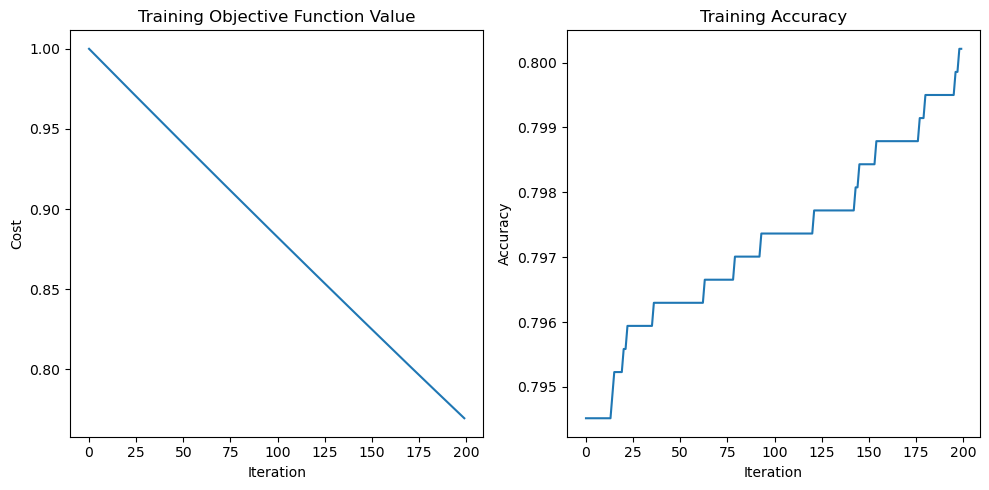

Classification Accuracy: 0.8165322580645161
F1 Score: 0.4276729559748428


In [4]:
# training the model
cost_all, w_all = linear_gd_train(train_X_cls, train_y_cls)

# plotting accuracy and cost per iteration on training set
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(cost_all)), cost_all)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Training Objective Function Value')

train_y_pred_cls = linear_predict(train_X_cls, w_all[-1])
train_accuracy = np.mean(train_y_pred_cls == train_y_cls)

plt.subplot(1, 2, 2)
plt.plot(range(len(w_all)), [np.mean(linear_predict(train_X_cls, w) == train_y_cls) for w in w_all])
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

# apply imputation to the test set
test_X_cls_imputed = imputer.transform(test_X_cls)
test_X_cls_imputed = scaler.transform(test_X_cls_imputed)

# predict on test set
test_y_pred_cls = linear_predict(test_X_cls_imputed, w_all[-1])

# compute accuracy and f1
test_accuracy = np.mean(test_y_pred_cls == test_y_cls)
f1_score = sklearn.metrics.f1_score(test_y_cls, test_y_pred_cls)

# report accuracy and f1 
print("Classification Accuracy:", test_accuracy)
print("F1 Score:", f1_score)

### 2.2 Learning Rate Analysis (3 marks)

The learning rate $\eta$ (Greek letter "eta") is a key parameter that affects the model training and performance. Design an appropriate experiment to demonstrate the effect of $\eta$ on model training, and on the model performance during testing.

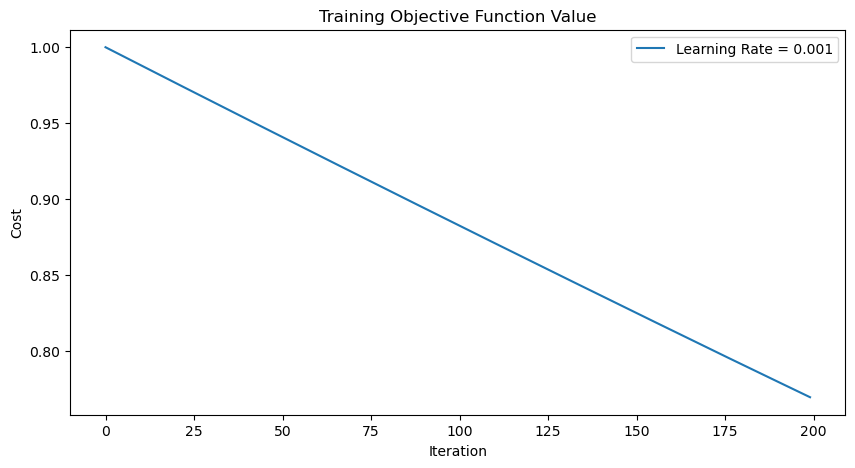

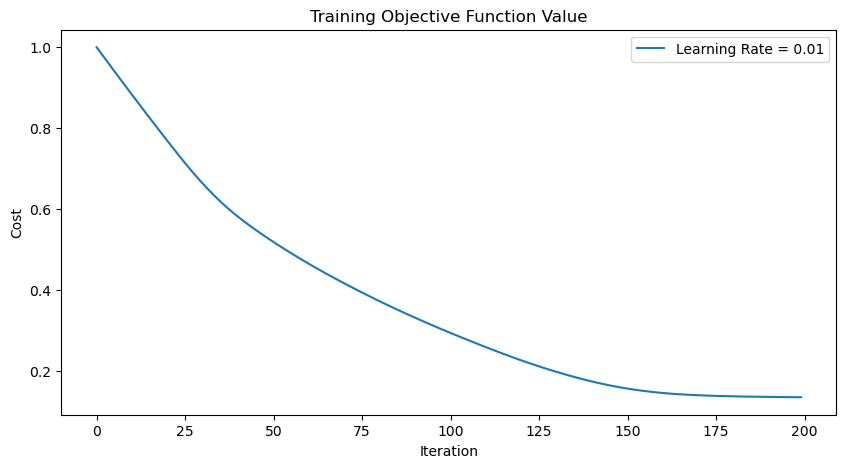

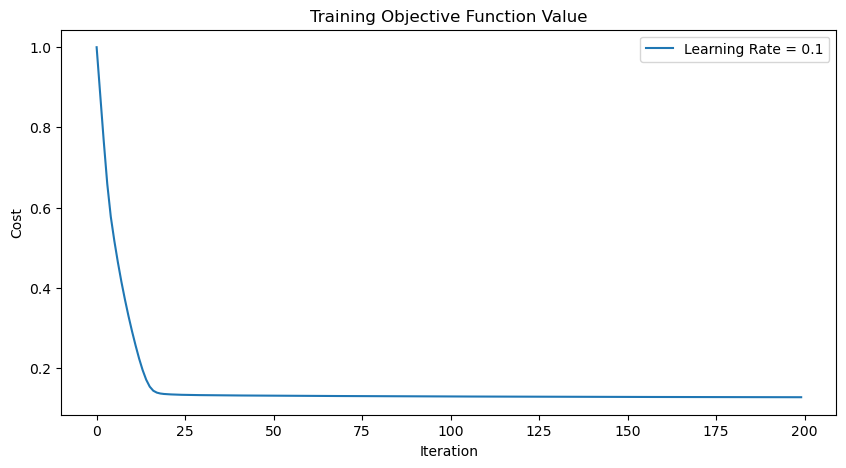

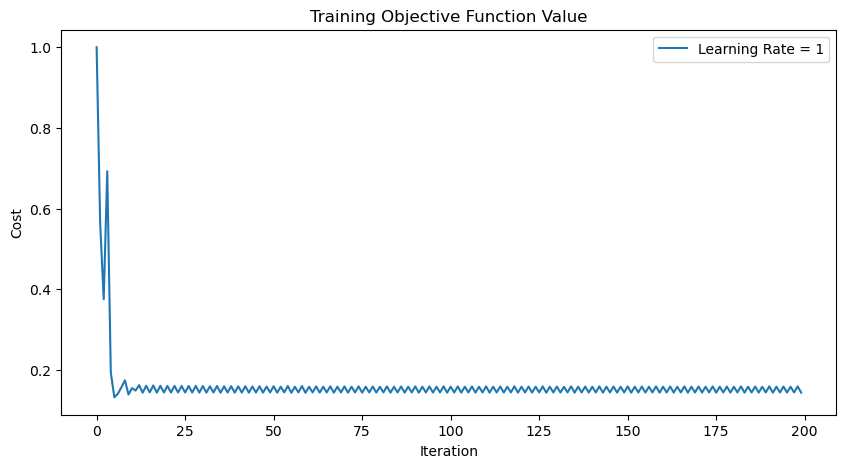

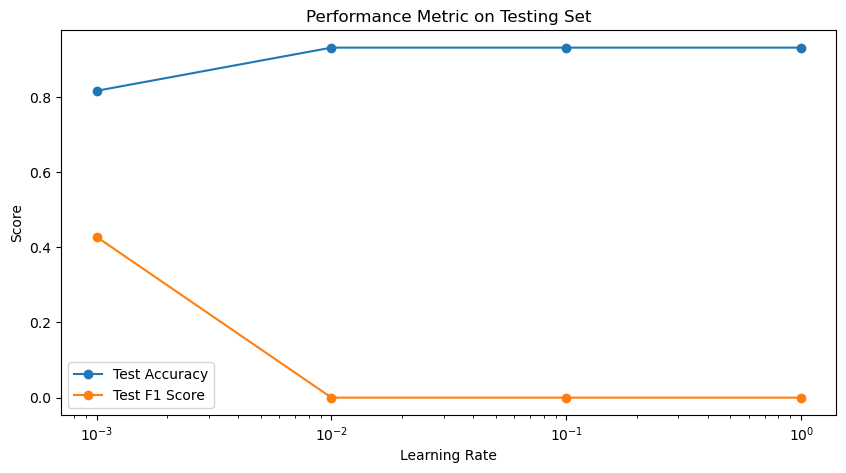

In [5]:
# Your code here
learning_rates = [0.001, 0.01, 0.1, 1]
test_accuracy_scores = []
test_f1_scores = []
training_objective_values = []

for learning_rate in learning_rates:
    # Train the model with the current learning rate
    cost_all, w_all = linear_gd_train(train_X_cls, train_y_cls, learning_rate=learning_rate)
    
    # Compute training objective function value over iterations
    training_objective_values.append(cost_all[-1])
    
    # Evaluate the model on the testing set
    test_y_pred_cls = linear_predict(test_X_cls_imputed, w_all[-1])
    
    # Compute accuracy and F1 score on the testing set
    test_accuracy = np.mean(test_y_pred_cls == test_y_cls)
    test_f1 = sklearn.metrics.f1_score(test_y_cls, test_y_pred_cls)
    
    test_accuracy_scores.append(test_accuracy)
    test_f1_scores.append(test_f1)
    
    # Plot training objective function value over iterations for the current learning rate
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(cost_all)), cost_all, label=f'Learning Rate = {learning_rate}')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Training Objective Function Value')
    plt.legend()
    plt.show()

# Plot performance metric (accuracy or F1 score) on testing set for each learning rate
plt.figure(figsize=(10, 5))
plt.plot(learning_rates, test_accuracy_scores, label='Test Accuracy', marker='o')
plt.plot(learning_rates, test_f1_scores, label='Test F1 Score', marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Performance Metric on Testing Set')
# logarithmic scale for better visualization
plt.xscale('log') 
plt.legend()
plt.show()

### 2.3 Report (6 Marks)
Answer the following questions in your report, to be submitted separately:
1. Derive step-by-step the gradient of the provided training objective function $O$, and the updating equation of your model weights based on gradient descent. (3 marks)

2. What does the figure from section 2.1 tell you, and what is the indication of the classification accuracies of your training and testing sets? (1 mark)

3. Comment on the effect of $\eta$ on model training, and on the model performance during testing, based on your results observed in Section 2.2. (2 marks)

## 3. Air Quality Analysis by Neural Network (10 marks)

In this experiment, you will predict the CO(GT) value based on the other 11 variables through regression. You will use a neural network to build a nonlinear regression model. Familiarise yourself with how to build a regression model by mutlilayer perceptron (MLP) using the scikit learn tutorial (https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression). 


### 3.1 Simple MLP Model Selection (4 marks)

This section is focused on the practical aspects of MLP implementation and model selection. We will first compare some model architectures. 

The set of MLP architectures to select is specified in `param_grid` below, including two MLPs with one hidden layer, where one has a small number of 3 hidden neurons, while the other has a larger number of 100 hidden neurons, and two MLPs with two hidden layers, where one is small (3, 3) and the other is larger (100, 100). It also includes two activation function options, i.e., the logistic and the rectified linear unit ("relu").  These result in a total of 8 model options, where sklearn default parameters are used for all the MLPs and their training. 

In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {   
        'hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
        'activation': ['relu', 'logistic'],
    },
]

Your code below should do the following: Split the dataset into the training and testing sets. Preprocess the data by imputing the missing features. Use the training set for model selection by cross-validation, and use mean squared error (MSE) as the model selection performance metric. You can use the scikit-learn module [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) to conduct grid search. Print the cross-validation MSE with standard deviation of the selected model. Re-train the selected model using the whole training set, and print its MSE and $R^2$ score for the testing set.  


In [7]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# split for regression
X = sensor_data_full.drop(columns=['CO(GT)'])
y = sensor_data_full['CO(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# preprocess the data
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# define MLP model
mlp = MLPRegressor(max_iter=10000)

# initialise and fit the grid search
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_imputed, y_train)

# report the best parameters and the CV results
print("Best Parameters:", grid_search.best_params_)
print("Best CV MSE:", -grid_search.best_score_)
print("CV MSE Standard Deviation:", grid_search.cv_results_['std_test_score'][grid_search.best_index_])

# re-train model
best_model = grid_search.best_estimator_
best_model.fit(X_train_imputed, y_train)

# report model performance
y_pred = best_model.predict(X_test_imputed)
test_mse = mean_squared_error(y_test, y_pred)
test_r2_score = r2_score(y_test, y_pred)
print("Testing MSE:", test_mse)
print("Testing R-squared Score:", test_r2_score)


Best Parameters: {'activation': 'logistic', 'hidden_layer_sizes': (100, 100)}
Best CV MSE: 0.3492941342290953
CV MSE Standard Deviation: 0.058062568127279536
Testing MSE: 0.379089189588043
Testing R-squared Score: 0.8223921520789275


### 3.2 Training Algorithm Comparison: SGD and ADAM (2 Marks)

In this exercise, you will compare two training algorithms, stochastic gradient descent (SGD) and ADAM optimisation, for training an MLP with two hidden layers each containing 100 neurons with "relu" activation, under the settings specified in `test_params` as below.

In [8]:
test_params = [
    {
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'solver': 'adam'
    },{
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'learning_rate': 'adaptive', 
        'momentum': 0.95, 
        'solver': 'sgd'
    },
]

Write the code below, where each training algorithm should run for 300 iterations (make sure to set `early_stopping=False`). For both algorithms, (1) plot the training loss (use the defaul loss setting in sklearn), as well as the MSE of both training and testing sets, over iterations; and (2) print the MSE and $R^2$ score of the trained model using the testing set. 


Algorithm: ADAM
Testing MSE: 0.2042971824886328
Testing R-squared Score: 0.9042843111470009


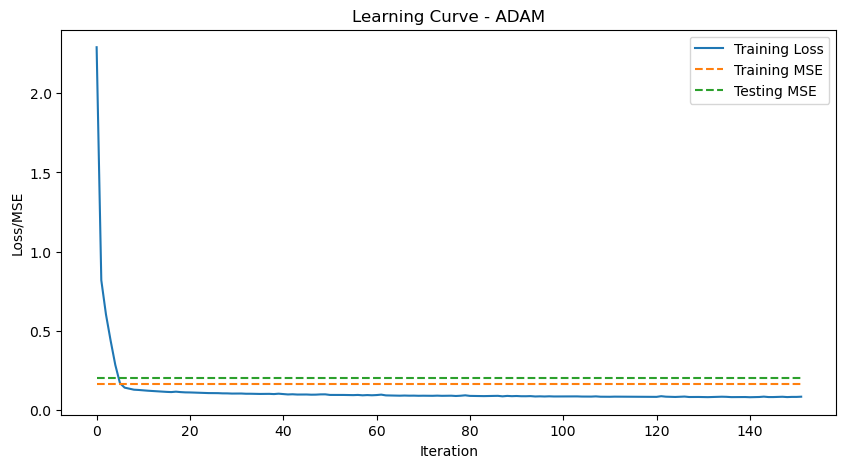


Algorithm: SGD
Testing MSE: 0.21234452298868828
Testing R-squared Score: 0.9005140352674483


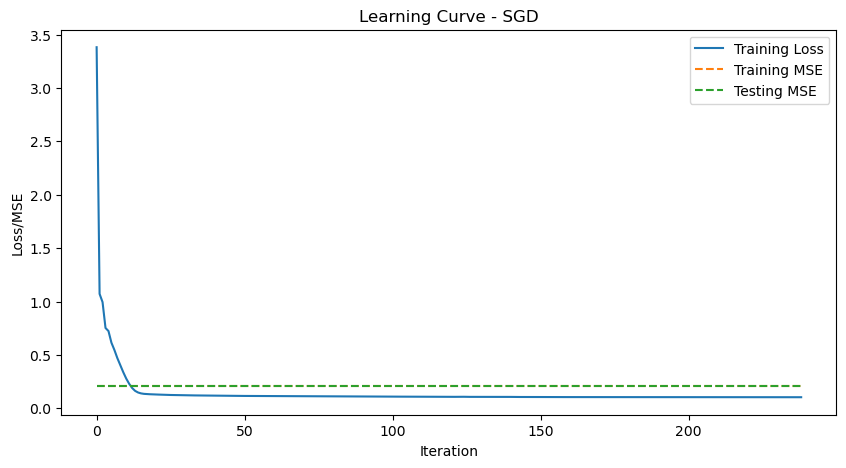

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Define the training algorithms
algorithms = ['ADAM', 'SGD']

# utilizing MinMaxScaler
scaler = MinMaxScaler()

# Preprocess the training and testing sets
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train models and plot learning curves
for i, params in enumerate(test_params):
    # Initialize the MLP regressor
    mlp = MLPRegressor(max_iter=300, **params)
    
    # Train the model
    try:
        mlp.fit(X_train_scaled, y_train)
        # would not run properly without this exception
    except Exception as e:
        print(f"Error encountered while training {algorithms[i]} model:", e)
        continue
    
    # Predictions on training and testing sets
    y_train_pred = mlp.predict(X_train_scaled)
    y_test_pred = mlp.predict(X_test_scaled)
    
    # Calculate MSE for training and testing sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Calculate R-squared score for testing set
    test_r2_score = r2_score(y_test, y_test_pred)
    
    # Print MSE and R-squared score for testing set
    print(f"\nAlgorithm: {algorithms[i]}")
    print("Testing MSE:", test_mse)
    print("Testing R-squared Score:", test_r2_score)
    
    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(mlp.loss_curve_, label='Training Loss')
    plt.plot(range(len(mlp.loss_curve_)), [train_mse] * len(mlp.loss_curve_), linestyle='--', label='Training MSE')
    plt.plot(range(len(mlp.loss_curve_)), [test_mse] * len(mlp.loss_curve_), linestyle='--', label='Testing MSE')
    plt.xlabel('Iteration')
    plt.ylabel('Loss/MSE')
    plt.title(f'Learning Curve - {algorithms[i]}')
    plt.legend()
    plt.show()

### 3.3 Report (4 Marks)
Answer the following questions in your report, to be submitted separately:
1. What conclusions can you draw based on your model selection results in Section 3.1? (2 marks)

2. Comment on the two training algorithms based on your results obtained in Section 3.2. (2 marks)

## 4.  Build A Robust MLP Regressor (6 Marks)

In this last experiment, you will develop and submit a robust MLP regressor to predict the CO(GT) value based on the other 11 variables, using the provided dataset. This robust regressor should account for the presence of missing and noisy features. 

Once you have developed your model, save it to a file using the provided `save_model` function for submission.

### 4.1 Model Development (3 Marks)

What you consider in model development should include (but not limited to) (1) handling of missing features in the unseen testing data, (2) handling of noisy features in the unseen testing data, and (3) a model selection practice.

Write your model development code below. Describe briefly in your report what you have considered in your model development.


In [10]:
# Your code here
mlp = MLPRegressor(max_iter=1000)

param_grid = {
    'hidden_layer_sizes': [(100, 100), (200, 200)],
    'activation': ['relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
}

grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

submitted_model = grid_search.best_estimator_

## 4.2 External Testing (3 Marks)
Save your trained model for submission, and submit it along with your notebook and report. It will be run and evaluated on a test set unseen by you.

**Important: set your university username (e.g. mbxxabc3) below when saving your model.** Failure to do this correctly would lead to your model not being marked!

In [11]:
import model_eval_utils

#### SAVE YOUR MODEL
student_username = "m85305wb" # SET YOUR USERNAME HERE
model = submitted_model
model_eval_utils.save_model(student_username, model)

In [12]:
print(f"Total notebook run time: {time.time() - notebook_start_time:.0f} seconds")

Total notebook run time: 225 seconds


### Option to test your saved model
Use the `run_model()` function to make sure your saved model can be loaded and run before submitting.

Please note the score returned by `run_model()` is not in any way indicative of your final mark. This is just a simple test to make sure your model can be loaded and run. When testing your model, the GTA will run your model following the practice below, but replacing the bunk_data with the testing data.

In [13]:
# some bunk data
bunk_data = np.array([[ 1.22400000e+03,  9.97440117e+00,
        9.76666667e+02,  2.50600000e+02,  5.71333333e+02,
        1.30700000e+02,  1.42433333e+03,  1.00166667e+03,
        2.32666664e+01,  3.57999992e+01,  1.00855762e+00],
    [ 9.24250000e+02,   3.97337806e+00,
        7.09250000e+02,  6.30000000e+01,  1.15800000e+03,
        7.50000000e+01,  1.31800000e+03,  6.09750000e+02,
        1.60500000e+01,  4.13500004e+01,  7.48680717e-01],
    [ 8.92000000e+02,  5.06611560e+00,
        7.66750000e+02,  7.10000000e+01,  1.18000000e+03,
        8.40000000e+01,  1.46600000e+03,  6.56750000e+02,
        1.79749999e+01,  5.14499998e+01,  1.05039283e+00]])
bunk_labels = np.array([2. , 1.3, 6.1])

score = model_eval_utils.run_model(student_username, 
                                test_data=bunk_data, 
                                test_labels=bunk_labels, 
                                model_folder=".")

Attempting to load from ....
Loaded .\m85305wb.sav model.
Model score: -15934802.445432035
